In [595]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.feature_selection import mutual_info_regression

from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.callbacks import EarlyStopping


In [596]:
plt.style.use("seaborn-whitegrid")

In [597]:
#Load data
test_df = pd.read_csv(r'C:\Repositorio\Housing Prices Competition\test.csv') #Test data to 

house_train_df = pd.read_csv(r'C:\Repositorio\Housing Prices Competition\train.csv') #Train data




In [598]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [599]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1044,1045,20,RL,80.0,9600,Pave,Grvl,Reg,Lvl,AllPub,...,0,Gd,MnPrv,Shed,0,7,2009,WD,Normal,278000
393,394,30,RL,60.0,7446,Pave,Grvl,Reg,Lvl,AllPub,...,0,Fa,GdWo,Shed,0,4,2006,WD,Abnorml,100000
1339,1340,20,RL,120.0,9560,Pave,Pave,IR1,Lvl,AllPub,...,0,Fa,GdWo,TenC,0,6,2006,WD,Normal,128500
1283,1284,90,RL,94.0,9400,Pave,Pave,Reg,Low,AllPub,...,0,Gd,GdWo,Shed,0,4,2010,WD,Normal,139000
141,142,20,RL,78.0,11645,Pave,Pave,Reg,Lvl,AllPub,...,0,Ex,MnPrv,Shed,0,1,2006,WD,Normal,260000


In [600]:
#Analize the NA data

missing = house_train_df.isnull().sum()

total = np.product(house_train_df.shape)
total_missing = missing.sum()

percent_missing = (total_missing/total) * 100

print(percent_missing)


5.889565364451209


In [601]:
#Clean the data
#1. Replace the Na with 0
house_train_df = house_train_df.fillna(method='bfill', axis=0)
house_train_df = house_train_df.dropna()

test_df = test_df.fillna(method='bfill', axis=0)
test_df = test_df.fillna(0)

list_id = test_df["Id"]


In [602]:
#Split the data

#train_df = house_train_df.sample(frac = 0.7, random_state=0)
#valid_df = house_train_df.drop(train_df.index)



# Split features and target
#X_train = train_df.drop('SalePrice', axis=1)
#X_valid = valid_df.drop('SalePrice', axis=1)
#y_train = train_df['SalePrice']
#y_valid = valid_df['SalePrice']


X = house_train_df.drop(['SalePrice'], axis=1)
y = house_train_df.SalePrice

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)



OverallQual     0.582106
Neighborhood    0.484526
GrLivArea       0.447950
TotalBsmtSF     0.368617
GarageCars      0.359038
GarageArea      0.355795
KitchenQual     0.340612
YearBuilt       0.339831
ExterQual       0.325797
1stFlrSF        0.306022
BsmtQual        0.293712
MSSubClass      0.288323
FullBath        0.266532
YearRemodAdd    0.239843
2ndFlrSF        0.239695
TotRmsAbvGrd    0.239274
Foundation      0.214426
GarageYrBlt     0.194508
OpenPorchSF     0.191945
GarageFinish    0.178264
Fireplaces      0.171189
Exterior2nd     0.161871
LotFrontage     0.160588
BsmtFinSF1      0.156591
HeatingQC       0.153487
GarageType      0.145161
LotArea         0.142171
WoodDeckSF      0.131015
MSZoning        0.129325
Exterior1st     0.129302
MasVnrArea      0.124303
BsmtFinType1    0.121458
BsmtUnfSF       0.116372
OverallCond     0.109722
HalfBath        0.094173
MasVnrType      0.079146
BedroomAbvGr    0.076054
HouseStyle      0.075139
CentralAir      0.072764
SaleType        0.071203


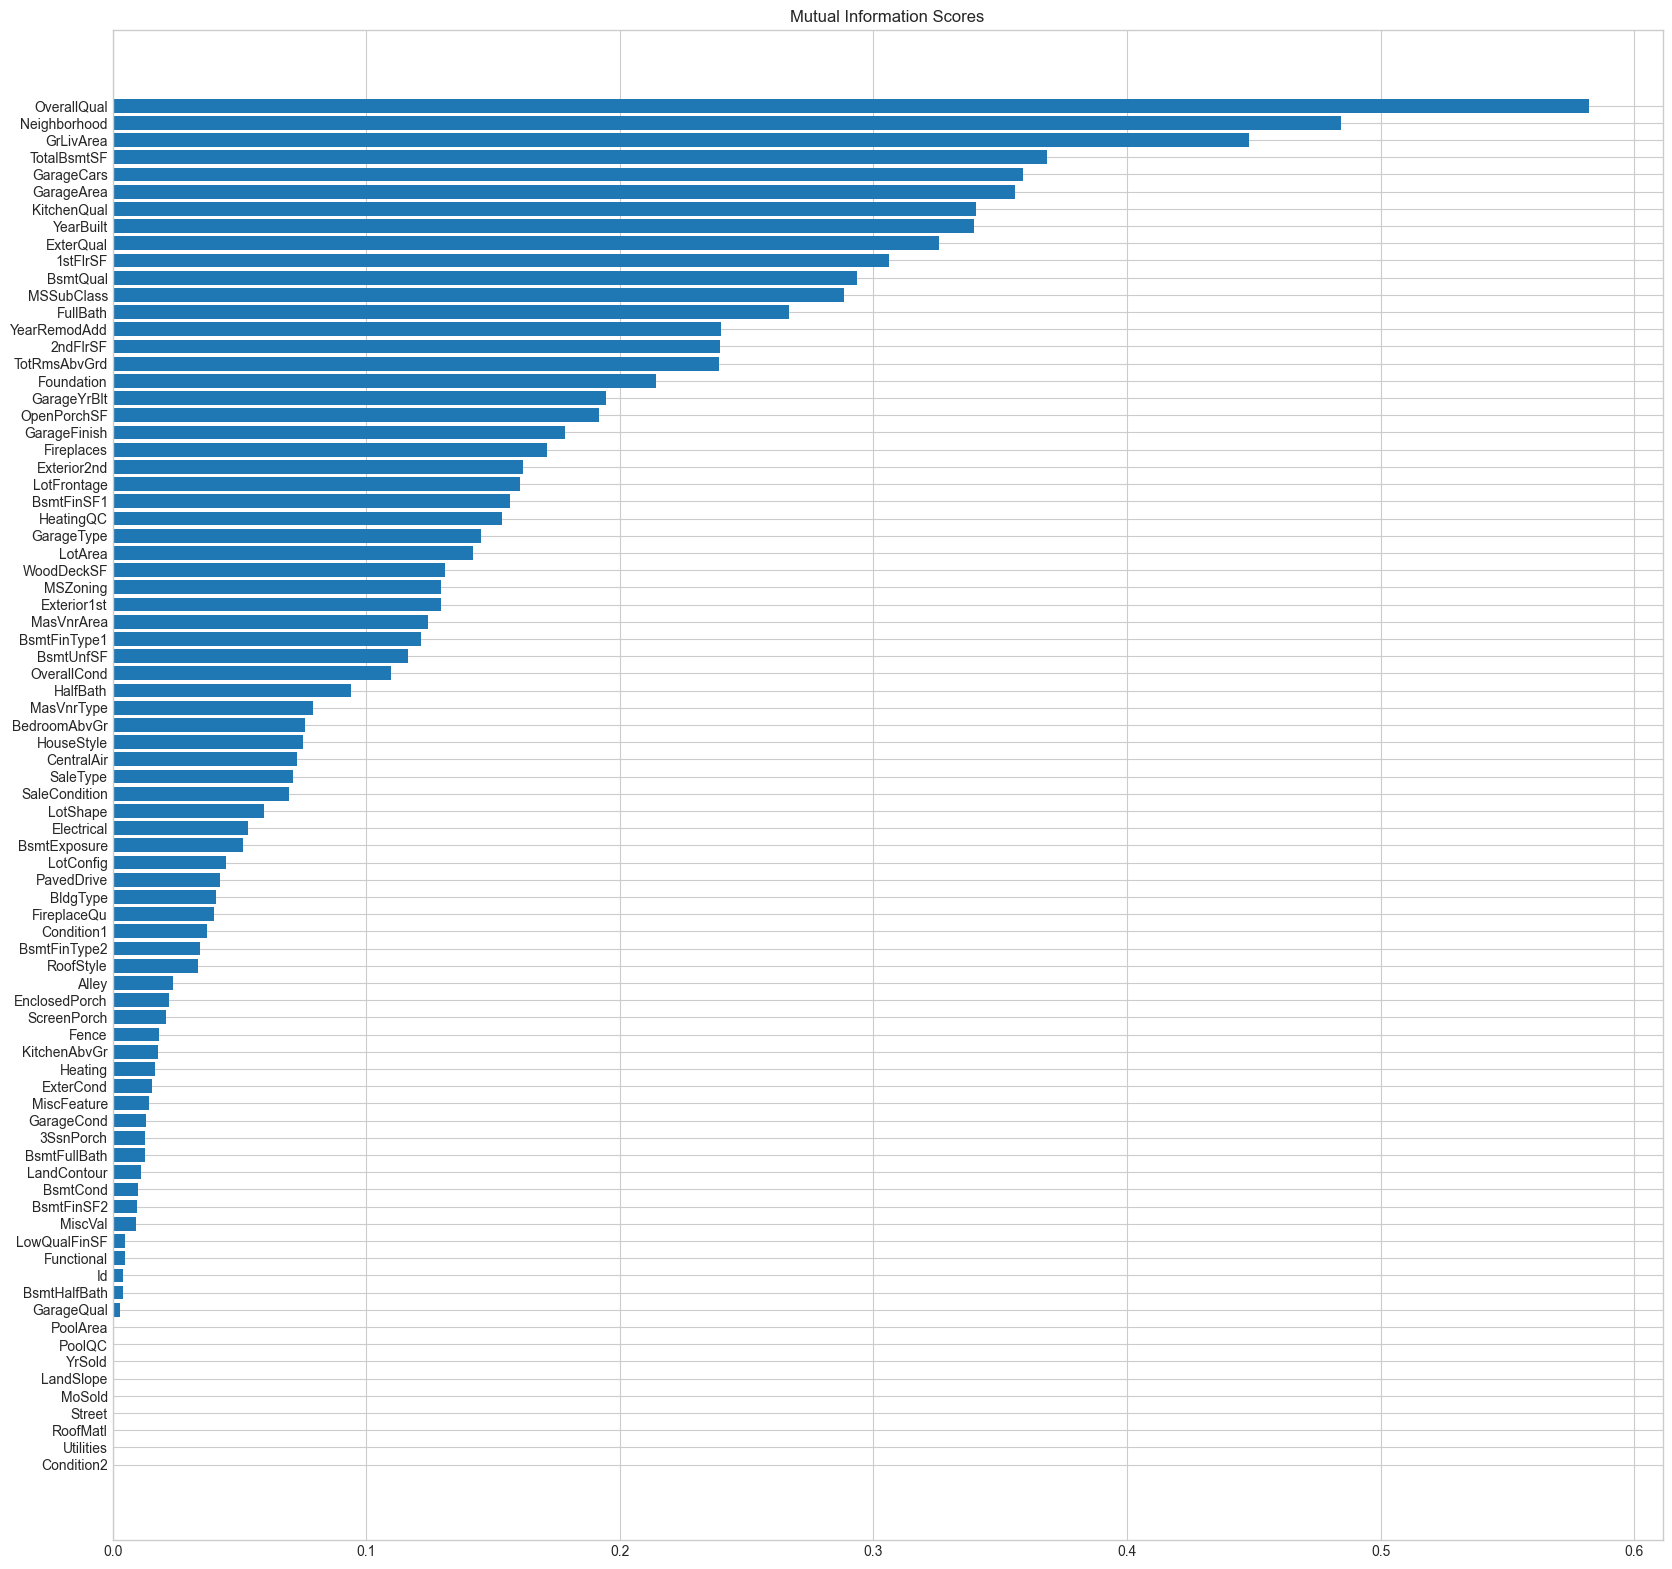

In [603]:
#Apliying mutual information to the data

X = train_df.copy()
y = X.pop("SalePrice")

#Label encoding
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

discrete_features = X.dtypes == int

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(20, 20))
plot_mi_scores(mi_scores)
mi_scores[:40] # show a few features with their MI scores

In [604]:
print(mi_scores)

OverallQual     0.582106
Neighborhood    0.484526
GrLivArea       0.447950
TotalBsmtSF     0.368617
GarageCars      0.359038
                  ...   
RoofMatl        0.000000
LandSlope       0.000000
MoSold          0.000000
Street          0.000000
Condition2      0.000000
Name: MI Scores, Length: 80, dtype: float64


In [605]:
#Drop the feautures with low impact (<0.1)
invalid_features =mi_scores[mi_scores < 0.1]  

print(invalid_features.index.to_list())

X_train = X_train.drop(columns=invalid_features.index.to_list())

X_valid = X_valid.drop(columns=invalid_features.index.to_list())

test_df = test_df.drop(columns=invalid_features.index.to_list())


['HalfBath', 'MasVnrType', 'BedroomAbvGr', 'HouseStyle', 'CentralAir', 'SaleType', 'SaleCondition', 'LotShape', 'Electrical', 'BsmtExposure', 'LotConfig', 'PavedDrive', 'BldgType', 'FireplaceQu', 'Condition1', 'BsmtFinType2', 'RoofStyle', 'Alley', 'EnclosedPorch', 'ScreenPorch', 'Fence', 'KitchenAbvGr', 'Heating', 'ExterCond', 'MiscFeature', 'GarageCond', '3SsnPorch', 'BsmtFullBath', 'LandContour', 'BsmtCond', 'BsmtFinSF2', 'MiscVal', 'LowQualFinSF', 'Functional', 'Id', 'BsmtHalfBath', 'GarageQual', 'PoolArea', 'PoolQC', 'YrSold', 'Utilities', 'RoofMatl', 'LandSlope', 'MoSold', 'Street', 'Condition2']


In [606]:
#Categorical encoding 

# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

label_X_train = X_train.copy()
label_X_valid = X_valid.copy()
label_X_test = test_df.copy()

#Apply ordinal encoding

ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100)

label_X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
label_X_valid[object_cols] = ordinal_encoder.transform(X_valid[object_cols])
label_X_test[object_cols] = ordinal_encoder.transform(test_df[object_cols])


Categorical variables:
['MSZoning', 'Neighborhood', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtFinType1', 'HeatingQC', 'KitchenQual', 'GarageType', 'GarageFinish']


In [607]:
#Define the model

model = keras.Sequential([
    layers.Dense(units=16, activation= 'relu', input_shape=[34]),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mae",
)

In [608]:
#Creating an early stoping

early_stopping = EarlyStopping(
    min_delta=1, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [609]:
#Train the model

history = model.fit(
    label_X_train, y_train,
    validation_data=(label_X_valid, y_valid),
    batch_size=50,
    epochs=1000,
    callbacks=[early_stopping], # put your callbacks in a list
)


Epoch 1/1000
23/23 [==============================] - 2s 27ms/step - loss: 182113.1562 - val_loss: 180544.3750
Epoch 2/1000
23/23 [==============================] - 0s 7ms/step - loss: 181289.0469 - val_loss: 179750.8281
Epoch 3/1000
23/23 [==============================] - 0s 5ms/step - loss: 180353.4844 - val_loss: 178608.5625
Epoch 4/1000
23/23 [==============================] - 0s 7ms/step - loss: 178853.0625 - val_loss: 176676.5781
Epoch 5/1000
23/23 [==============================] - 0s 7ms/step - loss: 176212.9062 - val_loss: 173071.5000
Epoch 6/1000
23/23 [==============================] - 0s 4ms/step - loss: 171555.5469 - val_loss: 167251.1875
Epoch 7/1000
23/23 [==============================] - 0s 4ms/step - loss: 164500.1250 - val_loss: 158836.1875
Epoch 8/1000
23/23 [==============================] - 0s 3ms/step - loss: 154544.4219 - val_loss: 147241.6250
Epoch 9/1000
23/23 [==============================] - 0s 3ms/step - loss: 141419.0312 - val_loss: 132410.4375
Epoch 10/

Minimum validation loss: 27520.626953125


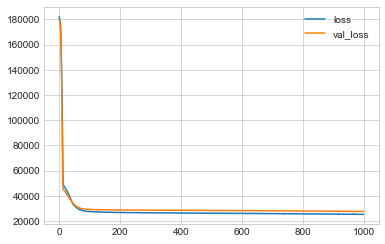

In [610]:
#Analize the results

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [611]:
results = model.predict(label_X_test)

final_result = []
for data in results:
    for result in data:
        final_result.append(result)


results_df = pd.DataFrame(list(zip(list_id, final_result)), columns = ["id","SalePrice"])

results_df.to_csv(r'C:\Repositorio\Housing Prices Competition\Results.csv', index = False)



